In [2]:
%cd /kaggle/input/chemcancer-v2/src/

/kaggle/input/chemcancer-v2/src


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tensorflow.keras.optimizers import Adam
from data import *
from machine_learning_models import *
from deep_learning_models import *
from vision_transformer import *
from utils_dl_model import *
from utils_ml_model import print_ml_results
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

In [5]:
import random
from dataclasses import dataclass
import pandas as pd
import numpy as np
import tensorflow as tf


@dataclass
class RamanDataGenerator(tf.keras.utils.Sequence):
    df: pd.DataFrame
    batch_size: int
    max_classes: int

    weighted_sum: bool = True
    roll: bool = True
    roll_factor: int = 12

    slope: bool = True
    slope_factor: float = 0.2

    noise: bool = True
    noise_range: tuple = (80, 100)

    sparse_labels: bool = False

    def __post_init__(self):
        # transform to numpy for performance reasons
        self.samples = self.df.drop(columns=["labels"]).to_numpy().astype("float32")
        self.labels = self.df.loc[:, "labels"].to_numpy().astype("uint32")

    def __len__(self):
        return int(len(self.df) // self.batch_size)

    def __getitem__(self, index):
        # selection of mini-batch
        BOTTOM = index * self.batch_size
        TOP = (index + 1) * self.batch_size
        batch_samples = self.samples[BOTTOM:TOP]
        batch_labels = self.labels[BOTTOM:TOP].reshape((self.batch_size, 1))

        batch_samples = self._augmentation(batch_samples, batch_labels)
        batch_labels = batch_labels.reshape((self.batch_size,))

        # in case of categorical crossentropy loss, labels are translated
        # form sparse to categorical
        if not self.sparse_labels:
            batch_labels = tf.keras.utils.to_categorical(
                batch_labels, num_classes=self.max_classes
            )

        return (
            batch_samples,
            batch_labels,
        )

    def _augmentation(self, batch_samples, batch_labels):
        """Compute data augmentation on 'batch_samples', applying 
        weighted sum + roll(horizontal shift) + baseline noise + adittive white gaussian noise

        Args:
            batch_samples (np.array): Batch of spectra (1d array)
            batch_labels (np.array): Batch of label, number that are class identifier

        Returns:
            np.array: Batch of augmented data
        """

        if self.weighted_sum:
            alpha = np.random.rand(self.batch_size)

            other_samples = np.apply_along_axis(
                self._get_random_sample_from_class, 1, batch_labels
            ).reshape(self.batch_size, batch_samples.shape[1])

            if self.roll:
                other_samples = np.apply_along_axis(self._random_roll, 1, other_samples)

            batch_samples = (
                np.multiply(
                    batch_samples - other_samples, alpha.reshape(self.batch_size, 1)
                )
                + other_samples
            )

        if self.slope:
            batch_samples = np.apply_along_axis(
                lambda x: self._produce_background_baseline(x, batch_samples.shape[1]),
                1,
                batch_samples,
            )

        if self.noise:
            batch_samples = np.apply_along_axis(self._random_noise, 1, batch_samples)

        return batch_samples

    def _get_random_sample_from_class(self, label):
        """Extract a random sample from the datas marked as 'label'

        Args:
            label (int): Number that describe the class identifier of data to select

        Returns:
            np.array: Random sample of the 'label' class
        """
        class_indexes = np.where(self.labels == label)[0]
        CLASS_INDEX = np.random.choice(class_indexes, 1)[0]

        return self.samples[CLASS_INDEX : CLASS_INDEX + 1]

    def _random_noise(self, arr):
        """Apply adittive white gaussian noise to 'arr' of magnitued 'noise_range'

        Args:
            arr (np.array): Sample to wich apply the noise

        Returns:
            np.array: Noise 'arr'
        """
        rnd_snr = random.randint(self.noise_range[0], self.noise_range[1])
        NOISE_FACTOR = 1 / (10 ** (rnd_snr / 10))

        return arr + np.random.normal(0, NOISE_FACTOR, len(arr))

    def _random_roll(self, arr):
        """Apply random roll (numpy way to say horizontal shift) to 'arr' of magnitude 'roll_factor'

        Args:
            arr (np.array): Sample to wich apply the roll

        Returns:
            np.array: Random rolled sample
        """

        SHIFT_FACTOR = self.roll_factor
        random_shift = random.randint(-1 * SHIFT_FACTOR, SHIFT_FACTOR)

        rolled = np.roll(arr, random_shift)
        padded = (
            np.pad(rolled[random_shift:], (random_shift, 0), "edge")
            if random_shift >= 0
            else np.pad(rolled[:random_shift], (0, abs(random_shift)), "edge")
        )

        return padded

    def _produce_background_baseline(self, arr, steps):
        """Apply a random baseline noise to 'arr' of magnitude 'slope_factor' 

        Args:
            arr (np.array): Spectrum to wich apply the baseline noise
            steps (int): Length of the 'arr' argument

        Returns:
            np.array: Noised spectrum
        """

        SLOPE = random.triangular(-1 * self.slope_factor, self.slope_factor)
        line = (
            np.linspace(abs(SLOPE), 0, steps)
            if SLOPE < 0
            else np.linspace(0, SLOPE, steps)
        )

        alpha = random.random()

        return arr * alpha + line * (1 - alpha)

In [35]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming load_data and extract_data are defined elsewhere

# Load the data
data_file = "../Data/HC05_HC07.csv"
print("Load the data")
data = load_data(data_file)
print(f"Data shape: {data.shape}")

# Extract the feature and target data
print("Extract the feature and target data")
X, y = extract_data(data)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)

# Save to CSV
X_train_df.to_csv("/kaggle/working/X_train-ori.csv", index=False)
y_train_df.to_csv("/kaggle/working/y_train-ori.csv", index=False)
X_test_df.to_csv("/kaggle/working/X_test-ori.csv", index=False)
y_test_df.to_csv("/kaggle/working/y_test-ori.csv", index=False)


Load the data
Data shape: (2373, 274)
Extract the feature and target data
X shape: (2373, 270)
y shape: (2373,)
Training set size: 1898
Test set size: 475


In [36]:
ori_data = pd.DataFrame(X_train)
ori_data['labels'] = y_train
num_classes = len(np.unique(y_train))
batch_size = len(ori_data)

In [37]:
ori_data

,0,1,2,3,4,5,6,7,8,9,...,261,262,263,264,265,266,267,268,269,labels
0,581.2516,581.1943,581.0497,581.1522,581.0959,581.0723,581.2472,581.0346,581.3223,581.2276,...,580.6667,580.5652,580.4023,580.4405,580.3032,580.6525,580.1658,580.2284,580.2857,1
1,582.7891,582.8108,582.5608,582.5526,582.6357,582.5557,582.2891,582.6663,582.3320,582.6377,...,580.6038,580.7904,580.7570,581.0180,580.6324,580.6039,580.9680,580.6193,580.7481,2
2,585.7064,585.4607,585.4117,585.3944,585.0531,585.2131,585.6371,585.7014,585.6702,585.4004,...,581.3903,581.3832,581.5177,581.3098,581.2923,581.3803,581.3741,581.4734,581.3970,0
3,593.1833,592.4667,592.1667,591.9167,591.9500,592.0333,592.3666,592.5333,592.6334,592.3500,...,583.2500,583.0500,582.9833,583.2000,582.8666,582.9333,583.0667,583.1500,582.7167,0
4,578.5840,578.6880,578.9772,578.6871,578.7667,578.7864,578.7268,578.7081,578.7452,578.8312,...,578.4076,578.3552,578.3074,578.2919,578.3542,578.3547,578.3797,578.1716,578.2975,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1893,581.1169,580.9996,581.1188,580.9356,580.6577,581.1197,580.7742,580.8031,580.8167,580.8700,...,579.3338,579.0999,579.3660,579.2339,579.2827,579.3994,579.4834,579.3511,579.1998,2
1894,579.1511,578.9209,578.6824,578.8035,578.8539,578.9834,578.8819,578.9530,578.9643,578.8279,...,578.5167,578.2513,578.4721,578.3663,578.2343,578.2539,578.2162,578.6055,578.4015,1
1895,581.3333,581.3666,581.1834,581.6335,581.5499,581.3833,581.3667,581.4501,581.4833,581.4835,...,580.2477,580.0139,580.0864,580.2029,580.2819,580.1312,580.1337,580.1519,580.2148,1
1896,581.8881,581.8162,581.7989,581.7075,581.6561,581.8603,582.1224,581.8323,581.7870,581.8487,...,580.0018,580.0300,580.0225,579.9241,579.9863,580.1235,580.1838,580.0021,579.8179,1


In [9]:
import matplotlib.pyplot as plt

def visualize_generated_data(generator, x_samples_per_class):
    batch_data, batch_labels = generator[0]
    
    # If batch_labels are one-hot encoded, convert them to label encoding
    if len(batch_labels.shape) > 1 and batch_labels.shape[1] > 1:
        batch_labels = np.argmax(batch_labels, axis=1)
    
    unique_labels = np.unique(batch_labels)
    
    print(f"Unique labels in batch: {unique_labels}")  # Debugging line

    label_colors = {label: plt.cm.jet(i/len(unique_labels)) for i, label in enumerate(unique_labels)}
    
    for label in unique_labels:
        label_indices = np.where(batch_labels == label)[0][:x_samples_per_class]
        
        for index in label_indices:
            plt.plot(batch_data[index], color=label_colors[label], label=f"Class {label}")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    plt.title("Generated Raman Spectra")
    plt.xlabel("Wavenumber (cm^-1)")
    plt.ylabel("Intensity")
    plt.show()



In [10]:
def generate_augmented_data(df, multiplier=10, slope=False, roll=False, noise_range=(20,30)):
    
    # Collect augmented data over multiple batches
    all_data = []
    all_labels = []
    
    for _ in range(multiplier):
        # Instantiate a new generator for each iteration
        generator = RamanDataGenerator(df, batch_size=len(df), max_classes=len(np.unique(df['labels'])),
                                       slope=slope, roll=roll, noise_range=noise_range)
        batch_data, batch_labels = generator[0]
        all_data.append(batch_data)
        all_labels.append(batch_labels)
    
    # Concatenate the batches to get the final augmented dataset
    all_data = np.vstack(all_data)
    all_labels = np.concatenate(all_labels)
    
    return all_data, all_labels



In [40]:
# Generate data
noise_range = (20,30)
X_augmented, y_augmented = generate_augmented_data(ori_data, multiplier=10,slope=False, roll = False, noise_range = noise_range)

# Verify the size of the augmented dataset
print(X_augmented.shape, y_augmented.shape)

(18980, 270) (18980, 3)


Original Feature (Index 0) Summary Statistics:
 count    475.000000
mean     582.069785
std        3.818219
min      577.137300
25%      579.535950
50%      581.311700
75%      583.247550
max      612.418800
dtype: float64

Augmented Feature (Index 0) Summary Statistics:
 count    18980.000000
mean       582.047028
std          3.142377
min        576.994016
25%        580.240430
50%        581.494700
75%        582.971853
max        623.152330
dtype: float64


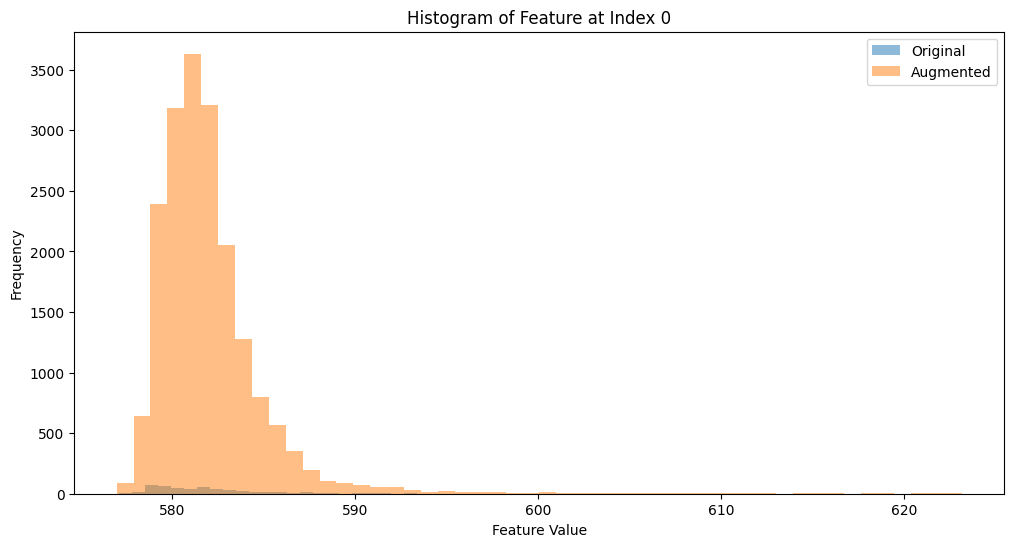

In [41]:
feature_index = 0  # Example feature index

original_feature = X_test[:, feature_index]
augmented_feature = X_augmented[:, feature_index]

print(f"Original Feature (Index {feature_index}) Summary Statistics:\n", pd.Series(original_feature).describe())
print(f"\nAugmented Feature (Index {feature_index}) Summary Statistics:\n", pd.Series(augmented_feature).describe())

# Histograms for the feature
plt.figure(figsize=(12, 6))
plt.hist(original_feature, bins=50, alpha=0.5, label='Original')
plt.hist(augmented_feature, bins=50, alpha=0.5, label='Augmented')
plt.title(f'Histogram of Feature at Index {feature_index}')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# visualize_generated_data(generator, 5)

In [42]:
def save_generated_data_to_csv(generator, filename="generated_data.csv"):
    # Extract the first batch from the generator
    batch_data, batch_labels = generator[0]
    
    # Convert one-hot encoded labels to integer labels
    int_labels = np.argmax(batch_labels, axis=1)
    
    # Convert the generated data to a DataFrame
    df_generated = pd.DataFrame(batch_data)
    df_generated['labels'] = int_labels
    
    # Save to CSV
    df_generated.to_csv(filename, index=False)

def save_data_to_csv(X, y, filename="augmented_data.csv"):
    # Convert one-hot encoded labels to integer labels
    if len(y.shape) > 1 and y.shape[1] > 1:
        y = np.argmax(y, axis=1)
    
    # Convert the data to a DataFrame
    df_augmented = pd.DataFrame(X)
    df_augmented['labels'] = y
    
    # Save to CSV
    df_augmented.to_csv(filename, index=False)

# Without the generate_augmented_data multiple

In [ ]:
# Usage
# save_generated_data_to_csv(generator, "/kaggle/working/gen-cc-nobksb.csv")

# With the generate_augmented_data multiple

In [43]:
# Usage
save_data_to_csv(X_augmented, y_augmented, "/kaggle/working/gen-cc-10x-v4.csv")
save_data_to_csv(X_test_df,y_test_df, "/kaggle/working/test-gen-cc-10x-v4.csv")